In [1]:
import pandas as pd

In [60]:
df = pd.read_csv('/Users/taewon/Documents/금융 빅데이터/project_1/select_data.csv', encoding='utf-8')

In [41]:
# # 데이터프레임에 파생변수 생성
# df['Exit'] = 0
# df.loc[(df['인수합병(MnA) 경험여부'] == 1) | (df['상장여부'] == 1), 'Exit'] = 1

In [44]:
# df.drop(columns=['회사주소_시(도)',	'한국표준산업분류(KSIC)코드_10차', '상장여부',	'인수합병(MnA) 경험여부','가중치'], inplace=True)

In [45]:
# df = df.loc[df['Exit'] == 0, :]

In [47]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# X: 독립 변수, y: 종속 변수
X = df.drop('벤처캐피털(투자조합포함) 투자 경험여부', axis=1)  # 종속 변수를 제외한 나머지 변수
y = df['벤처캐피털(투자조합포함) 투자 경험여부']  # 종속 변수

# StandardScaler를 사용하여 변수 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train set과 test set으로 분리 (test_size는 test set의 비율을 의미)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# test set에서 타겟 값이 0인 데이터만 선택
X_test = X_test[y_test == 0]
y_test = y_test[y_test == 0]


# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Autoencoder 모델 정의
model = Sequential()
model.add(Dense(14, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(7, activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(X_train.shape[1], activation='linear', activity_regularizer=regularizers.l1(0.001)))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# ModelCheckpoint 콜백 정의 (가장 우수한 성능을 가진 모델 저장)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

# TensorBoard 콜백 정의 (훈련 과정 저장)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# 모델 학습 코드

# 히스토리 객체 저장
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint, tensorboard])


# 모델 훈련
model.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_test, X_test), callbacks=[checkpoint, tensorboard])

# 테스트 데이터에서 예측 수행
reconstructed = model.predict(X_test)

# 예측 데이터의 재구성 오류 계산
reconstruction_error = np.mean(np.square(X_test - reconstructed))

# 저장된 최적 모델 로드
best_model = load_model('best_model.h5')


Epoch 1/100
310/310 [==============================] - 0s 786us/step - loss: 0.0755 - val_loss: 0.0699
Epoch 2/100
239/310 [======================>.......] - ETA: 0s - loss: 0.0650

/Users/taewon/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


310/310 [==============================] - 0s 589us/step - loss: 0.0642 - val_loss: 0.0676
Epoch 3/100
310/310 [==============================] - 0s 593us/step - loss: 0.0622 - val_loss: 0.0666
Epoch 4/100
310/310 [==============================] - 0s 582us/step - loss: 0.0611 - val_loss: 0.0659
Epoch 5/100
310/310 [==============================] - 0s 589us/step - loss: 0.0598 - val_loss: 0.0649
Epoch 6/100
310/310 [==============================] - 0s 579us/step - loss: 0.0590 - val_loss: 0.0646
Epoch 7/100
310/310 [==============================] - 0s 555us/step - loss: 0.0581 - val_loss: 0.0647
Epoch 8/100
310/310 [==============================] - 0s 568us/step - loss: 0.0573 - val_loss: 0.0645
Epoch 9/100
310/310 [==============================] - 0s 566us/step - loss: 0.0564 - val_loss: 0.0642
Epoch 10/100
310/310 [==============================] - 0s 576us/step - loss: 0.0553 - val_loss: 0.0627
Epoch 11/100
310/310 [==============================] - 0s 569us/step - loss: 0.0541

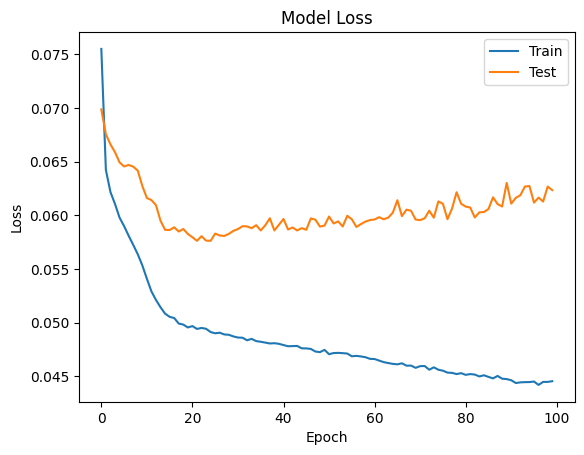

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [49]:
predictions = model.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

78/78 [==============================] - 0s 255us/step


,reconstruction_error,true_class
count,2477.000000,2477.000000
mean,0.518625,0.075091
std,1.090096,0.263591
min,0.019876,0.000000
25%,0.180311,0.000000
50%,0.315149,0.000000
75%,0.522781,0.000000
max,11.689829,1.000000


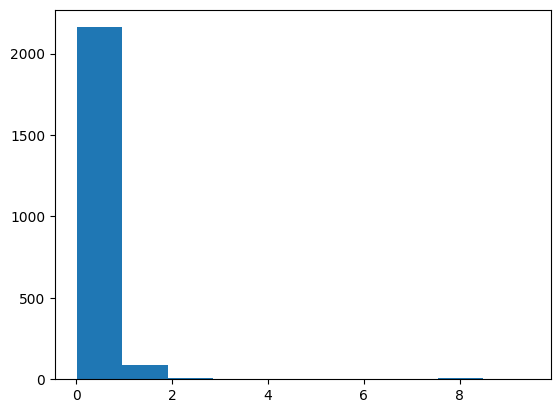

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

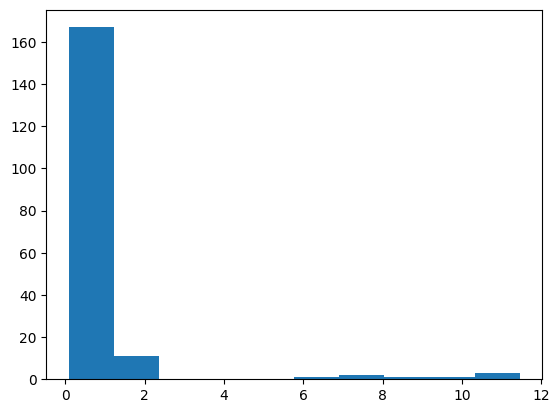

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

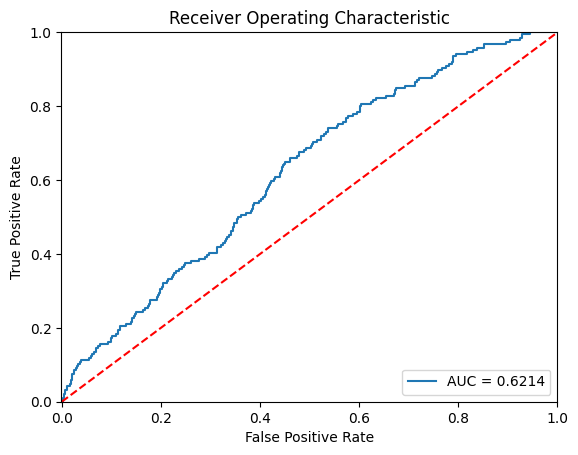

In [52]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


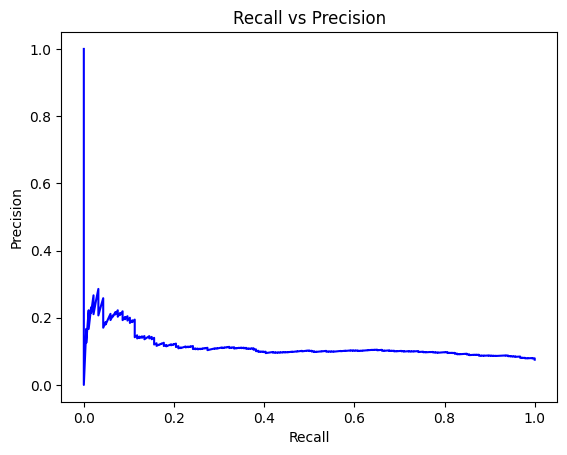

In [53]:
from sklearn.metrics import precision_recall_curve

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


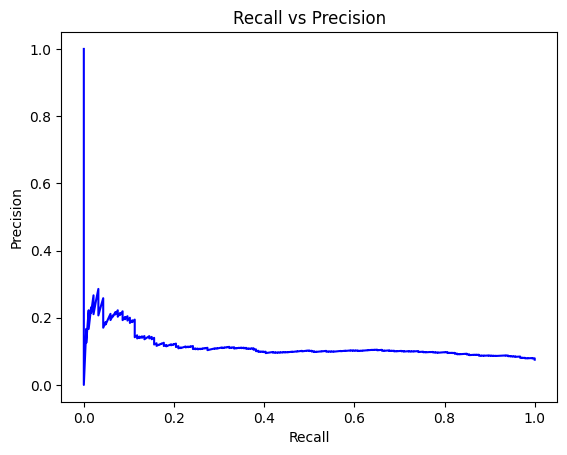

In [54]:
from sklearn.metrics import precision_recall_curve

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

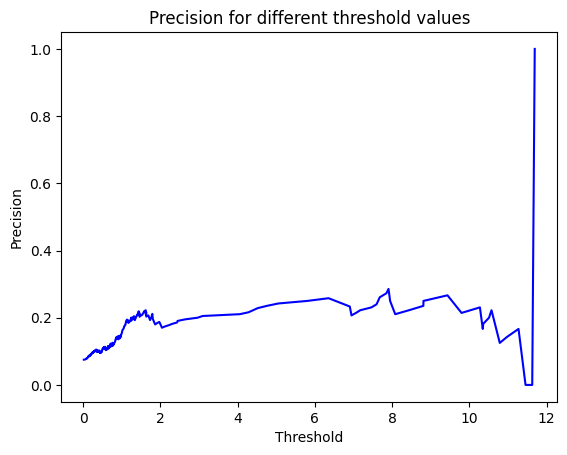

In [55]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

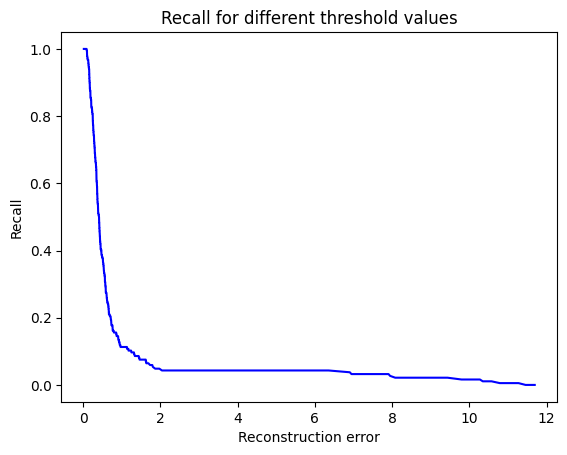

In [56]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [57]:
threshold = 2.9

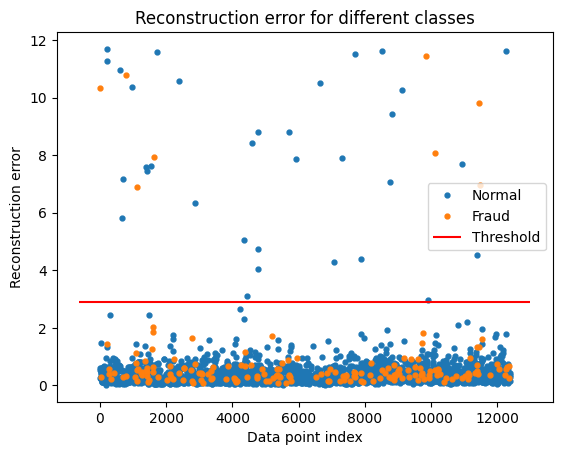

In [58]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index.values, group.reconstruction_error.values, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

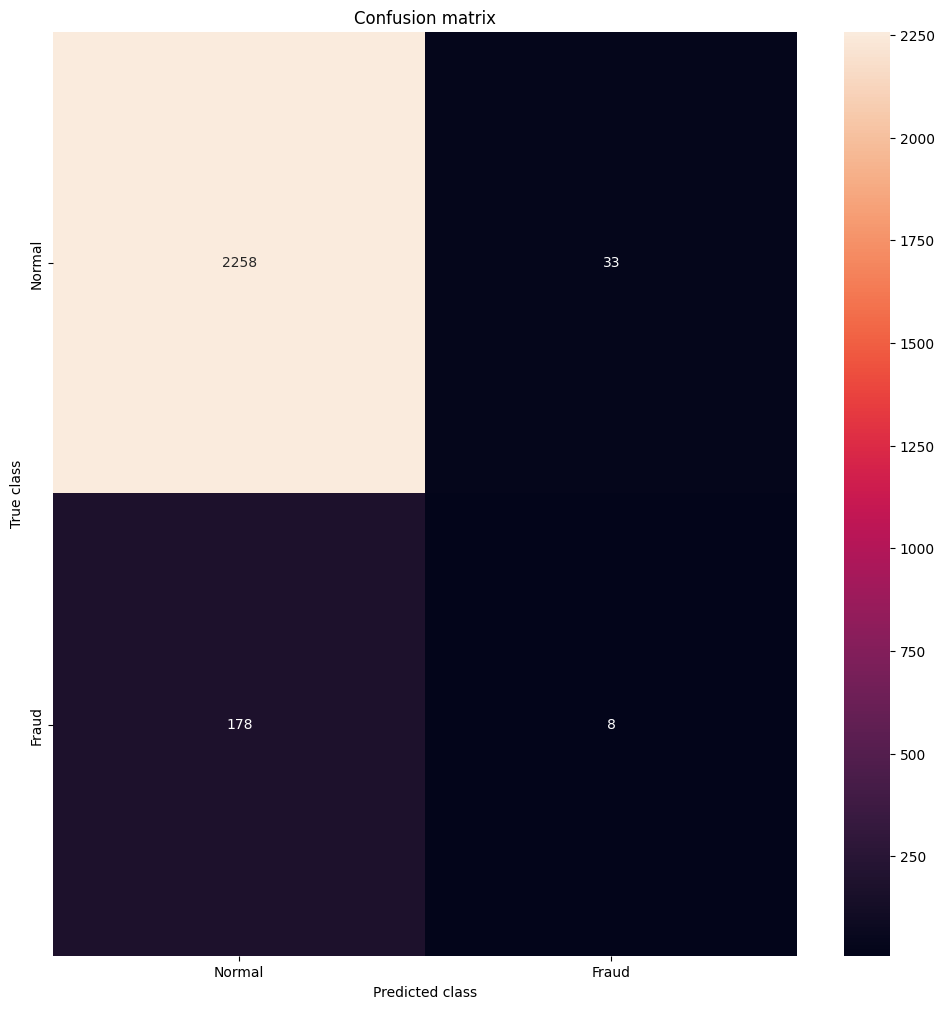

In [59]:
from sklearn.metrics import confusion_matrix

LABELS = ['Normal', 'Fraud']


y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()